In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import GRU, Dense

In [ ]:
df = pd.read_csv('Bitcoin Historical Data.csv')
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4019 entries, 0 to 4018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4019 non-null   object 
 1   Price   4019 non-null   float64
 2   Open    4019 non-null   float64
 3   High    4019 non-null   float64
 4   Low     4019 non-null   float64
 5   Vol.    4019 non-null   int64  
 6   Change  4019 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 219.9+ KB


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and day of year
df['Year'] = df['Date'].dt.year
df['DayOfYear'] = df['Date'].dt.day

# Convert to float (year + day of year / 365)
df['Date'] = df['Year'] + df['DayOfYear'] / 365

In [ ]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df).reshape(-1, 1))

In [ ]:
# 4. Chia train và test theo tỷ lệ 60-40
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
451/451 [==============================] - 25s 52ms/step - loss: 1.1579e-07
Epoch 2/100
451/451 [==============================] - 20s 44ms/step - loss: 1.0363e-08
Epoch 3/100
451/451 [==============================] - 20s 45ms/step - loss: 1.2523e-08
Epoch 4/100
451/451 [==============================] - 19s 43ms/step - loss: 1.7756e-08
Epoch 5/100
451/451 [==============================] - 21s 48ms/step - loss: 1.5827e-08
Epoch 6/100
451/451 [==============================] - 20s 45ms/step - loss: 1.6954e-08
Epoch 7/100
451/451 [==============================] - 22s 48ms/step - loss: 1.2013e-08
Epoch 8/100
451/451 [==============================] - 23s 51ms/step - loss: 1.2760e-08
Epoch 9/100
451/451 [==============================] - 21s 47ms/step - loss: 1.0866e-08
Epoch 10/100
451/451 [==============================] - 23s 51ms/step - loss: 1.1468e-08
Epoch 11/100
451/451 [==============================] - 23s 50ms/step - loss: 1.0237e-08
Epoch 12/100
451/451 [========

In [ ]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


223/223 [==============================] - 2s 9ms/step


In [ ]:
# 12. Đánh giá độ chính xác thuật toán
# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

# MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)


Testing RMSE: 130092388.53979659
Testing MAPE: inf
Testing MAE: 9068954.59094855


<ipython-input-31-b1e427629f97>:7: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1, 1)

temp_input = list(x_input[0])
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = time_step
i = 0

while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

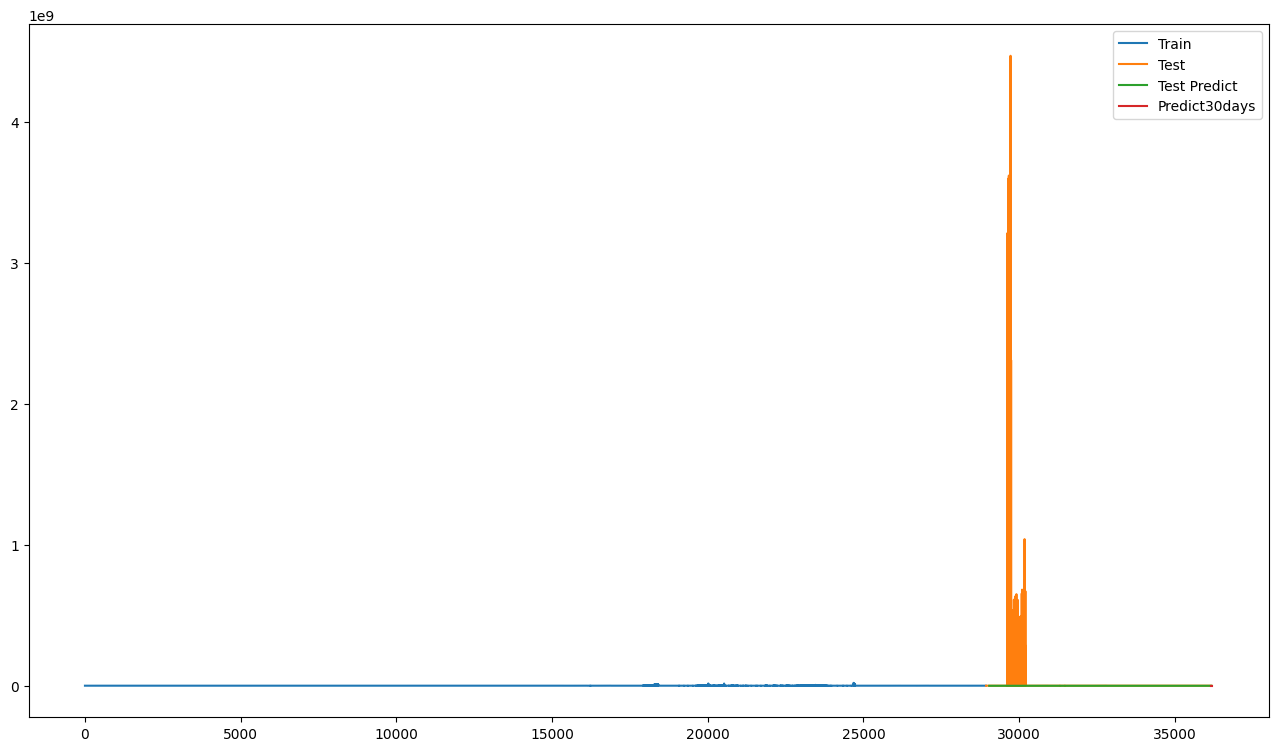

In [ ]:
# 14. Vẽ hình
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

predict_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output))

plt.legend(['Train', 'Test', 'Test Predict', 'Predict30days'])
plt.show()